# MSc in AI - CE6002 & CS5062


# E-tivity 4: Overfitting & How to Prevent It
# CE6002 - Performance of Classifiers - Tasks 1, 2 and 3

## Student Name: Mark Murnane
## Student ID: 18195326
-----

All necessary imports are provided. Please do not add further imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

Below is the exact same data you used for the regression in E-tivity 3, but this time you know exactly what function generated the data

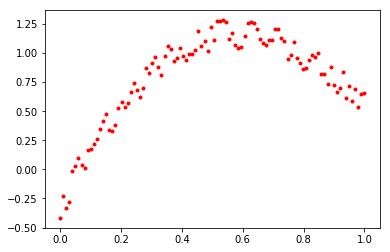

In [2]:
def target(X):
    #return: 0.5X^5-0.5X^3-4.25X^2+5.125X-0.4375
    return 0.5*((X-.5)-10*(X-.5)**2-(X-.5)**3+X**5)+1

points = 100
X = np.linspace(0, 1, points) # 100 values between 0 and 100
noise=np.random.random(points)/4
y_nf = target(X) #noise free target
y = y_nf+noise #noisy target

plt.plot(X,y,'r.')
plt.show()

Below is an implementation of linear regression with regularization

In [3]:
def weights_reg(X,y,l):
    n = len(X)
    m=X.T.dot(X)
    return np.linalg.inv(m+l*np.identity(m.shape[0])).dot(X.T).dot(y)

In [4]:
def lin_reg(w,X):
    # Calculation of outputs given weights and data (X). Note that X needs to contain the bias of 1. 
    out=[]
    for x in X:
        out.append(w.T.dot(x))
    return np.array(out)

In [5]:
def calc_error(w,X,y):
    # Calculate the error as the mean squared error
    pred = lin_reg(w,X)
    return math.sqrt((pred-np.array(y)).dot(pred-np.array(y))/len(X))

To create higher order features:

In [6]:
def transPoly(X, power):
    # Extend the data in X with a bias (1) and powers of the feature up to 'power'
    ones = np.ones((X.shape[0],1))
    extra=[]
    for x in X:
        row=[]
        for p in range(2,power+1):
            row.append(x**p)
        extra.append(row)
    return np.concatenate((ones, X.reshape(len(X),1),np.array(extra)),1)

## Task 4


Iterate over lambda, train the model and calculate Eout. Plot the latter versus lambda to see how much regularization is required.

------

### Task 4.1

### Determine optimal value of $\lambda$

After completing the other tasks after the Post last Saturday, I found that the values of $\lambda$ that worked best were low.  To give a better distribution that `np.linspace(0, 1, num=250)` the lambdas are now calculated using a log range between $10^{-6}$ and 1.  

The intention is to cover a range from overfitting (too small a $\lambda$) to underfitting (too large a $\lambda$).  By prepending $\lambda = 0$ in the range, the _unregularised_ function is also included.

In [7]:
ein=[]
eout=[]
weights=[]

# Calculate over a range from 0 to 1.  Expected to cover a range from underfitting to overfitting
lambdas = np.logspace(-6, 0, num=1000)
lambdas = np.insert(lambdas, 0, 0)
        
X_trans = transPoly(X,50)
# random_state fixed to get reproducible (and 'good'! :-)) results
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, train_size=0.9, random_state =5)
for l in lambdas:    
    w = weights_reg(X_train,y_train,l)
    ein.append(calc_error(w,X_train,y_train))
    eout.append(calc_error(w,X_test,y_test))
    weights.append(w)

D:\Masters\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


For now store the lowest values of $E_{in}$ and $E_{out}$ from the experiment and identify the lambda values that correspond to them.

In [8]:
# Get the minimum of both in- and out-of-sample errors
min_ein = np.amin(ein)
lambda_min_ein = lambdas[np.argmin(ein)]

min_eout = np.amin(eout)
lambda_min_eout = lambdas[np.argmin(eout)]

# For use later
weight_min_eout = weights[np.argmin(eout)]

### Compare to  unregularised $E_{out}$

The value of $E_{out}$ without regularisation can be calculated by using $\lambda = 0$.

In the calculations above we lambdas[0] = 0, therefore the values of ein[0] and eout[0] represent the unregularised values of $E_{in}$ and $E_{out}$ respectively.

In [9]:
print(f"The unregularised value of Eout is {eout[0]:.6f}")
print(f"The best regularised value of Eout is {min_eout:.6f} and used lambda = {lambda_min_eout:.6f}")

The unregularised value of Eout is 0.613666
The best regularised value of Eout is 0.077487 and used lambda = 0.000743


### Plot of $E_{out}$ vs. $\lambda$

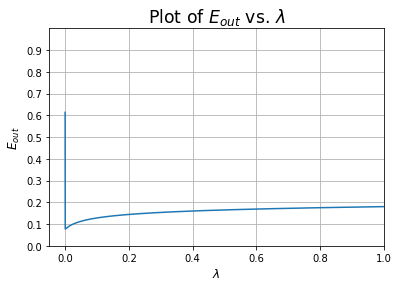

In [10]:
plt.plot(lambdas, eout)

plt.title("Plot of $E_{out}$ vs. $\lambda$", fontsize='xx-large')
plt.xlim(-0.05,1)
plt.xlabel("$\lambda$", fontsize='large')
plt.ylim(0,1)
plt.ylabel("$E_{out}$", fontsize='large')
plt.yticks(np.arange(0, 1, 0.1))
plt.grid()

plt.show()

### Plot overfit, underfit and optimal $\lambda$ models

After the initial post where the following code (mostly) was inline, decided to create a function so that it could be re-used for Task 5 and possibly Task 6.

In [11]:
def plot_lambda_models (lambda_vals, X_train, y_train):
    """Simple method to plot 3 lambda values.  Intended for overfit, optimal and underfit.

    Args:
        lambda_vals   Dictionary containing {model_name(str), lambda(float)} for each of 3 entries            
    """
    
    # Create the figure
    fig = plt.figure(figsize=(16,5))
    fig.suptitle("Comparison of Models", fontsize=20)

    # Plot each lambda_vals entry 
    for i, (plot, l_val) in enumerate(lambda_vals.items()):
        ax = fig.add_subplot(1, 3, i+1)

        # Plot the original function
        ax.plot(X,y,'r.')

        # Calculate and plot the the y values for the full spread of X (transposed to the higher order)
        model_w = weights_reg(X_train, y_train, l_val)
        model_y = lin_reg(model_w, X_trans)   
        ax.plot(X, model_y)  

        # Graph cleanup
        ax.set_title(f"Plot of {plot} model with $\lambda = {l_val:.6f}$", fontsize='large', fontstyle='italic')    
        ax.set_xlabel("X", fontsize='large', fontstyle='italic')
        ax.set_ylabel("y", fontsize='large', fontstyle='italic')

    # Adjust title for good spacing
    fig.subplots_adjust(top=0.85)

    plt.show()

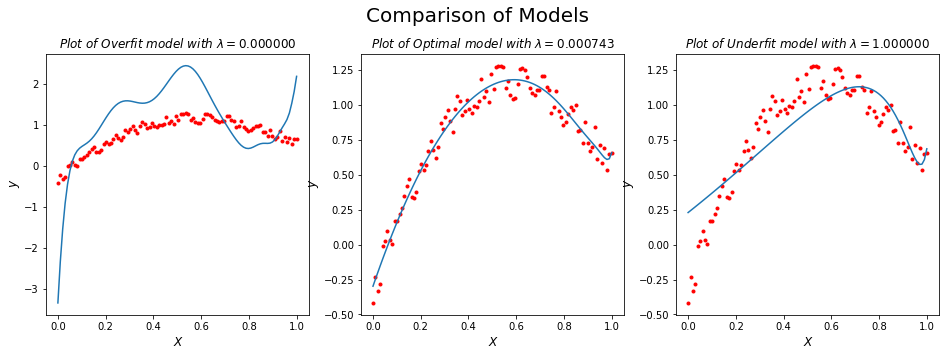

In [12]:
# Create the inputs for the plotting and call the plot function
plot_dict = {"Overfit": 0, "Optimal": lambda_min_eout, "Underfit": lambdas[-1]}

plot_lambda_models(plot_dict, X_train, y_train)

To show that the value of $\lambda = 1$ is in fact overfitting, we can use some high lambdas to show that those solutions don't look radically different.

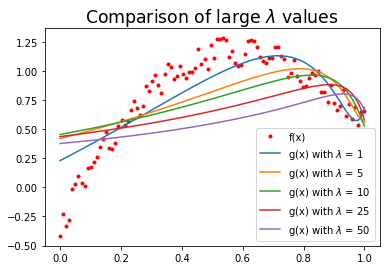

In [13]:
# Calculate new weights
test_lambda = [1, 5, 10, 25, 50]

plt.plot(X,y,'r.', label='f(x)')
plt.title("Comparison of large $\lambda$ values", fontsize='xx-large')

for l in test_lambda:
    test_w = weights_reg(X_train,y_train, l)
    test_y = lin_reg(test_w, X_trans)
    
    plt.plot(X, test_y, label=f'g(x) with $\lambda$ = {l}')

plt.legend()
plt.show()

## Task 5

Use 10-fold Cross Validation to optimise the value of lambda.

To show the process clearly, the data splitting steps are restarted from the original data set _X_ and targets _y_.

-----

### Task 5.1 - Calculate optimum value for $\lambda$

The approach to find an optimum value of $\lambda$ is:

 - Iterate over all of the values of $\lambda$ that you wish to check
 - Calculate the cross-validated estimate $E_{cv}$ for that $\lambda$.  
 - The $\lambda$ that generated the minimum value of $E_{cv}$  is the optimal $\lambda$.
 
Once we have the optimal $\lambda$ value we can use it to generate new weights, representing the final hypothesis $g_{m^*}$.  This can be used to evaluate the performance of the model using a held-out _Test_ set.

As the data has already been split above, *X_test* and *y_test* remain the held-out _Test_ set.



In [14]:
# Store the results of each fold (best results of experiment in fold)
cv_ein=[]
cv_eout=[]
cv_weight=[]
cv_lambda=[]

# Split the data into 10 folds for training.  Have the data shuffled before the split
# Shuffling will have been done by train_test_split so may not be required, but extra shuffle won't hurt
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

# For each lambda, need to train using CV
#                  need to calculate Ecv for that lambda

e_cv = []

for l in lambdas:

        # For the validation result of each fold
        e_val = []
    
        # Keep track of fold we're in, just in case
        for fold, (train_idx, test_idx) in enumerate(k_fold.split(X_train)):
            
            # Get the training and validation data sets
            Dtrain_X, Dval_X = X_train[train_idx], X_train[test_idx]
            Dtrain_y, Dval_y = y_train[train_idx], y_train[test_idx] 
            
            # Just calculate the validation accuracy here.  The in-sample is not relevant for optimising lambda
            w = weights_reg(Dtrain_X, Dtrain_y, l)
            e_val.append(calc_error(w,Dval_X, Dval_y))
            
        # Return the cross validation result for this lambda
        e_cv.append(np.mean(e_val))
        
        
# Now that we have the results, return the lambda with the lowest Ecv
min_e_cv = np.amin(e_cv)
opt_lambda = lambdas[np.argmin(e_cv)]

print(f"The lowest Ecv = {min_e_cv:.6f}\n")
print(f"The optimised value of lambda is: {opt_lambda:.6f}\n")

The lowest Ecv = 0.083703

The optimised value of lambda is: 0.000139



The final hypothesis $g_{m^*}$ # is the model trained with the optimal value of $\lambda$.

Determine $E_{out}$ based on the best combination of weights we got.

In [15]:
# Generate the model for the optimal lambda with full training data set
w_opt = weights_reg(X_train, y_train, opt_lambda)
e_out = calc_error(w_opt, X_test, y_test)

print(f"The value of Eout with the final hypotheses g_m is: {e_out:.6f}")

The value of Eout with the final hypotheses g_m is: 0.078753


### Task 5.2 - Plotting

-----

### Plot of $E_{cv}$ vs. $\lambda$

The following plot repeats the plot earlier, but this time using the cross-validated estimate $E_{cv}$.

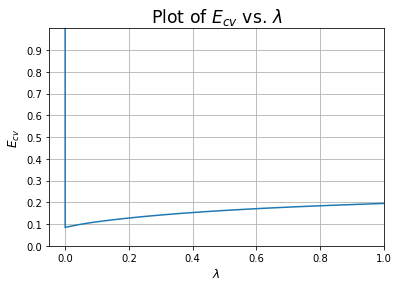

In [16]:
plt.plot(lambdas, e_cv)

plt.title("Plot of $E_{cv}$ vs. $\lambda$", fontsize='xx-large')
plt.xlim(-0.05,1)
plt.xlabel("$\lambda$", fontsize='large')
plt.ylim(0,1)
plt.ylabel("$E_{cv}$", fontsize='large')
plt.yticks(np.arange(0, 1, 0.1))
plt.grid()

plt.show()

### Plot overfit, underfit and optimal  λ  models

The following plots repeat the over, under and optimal fit models using the respective values of $\lambda$.

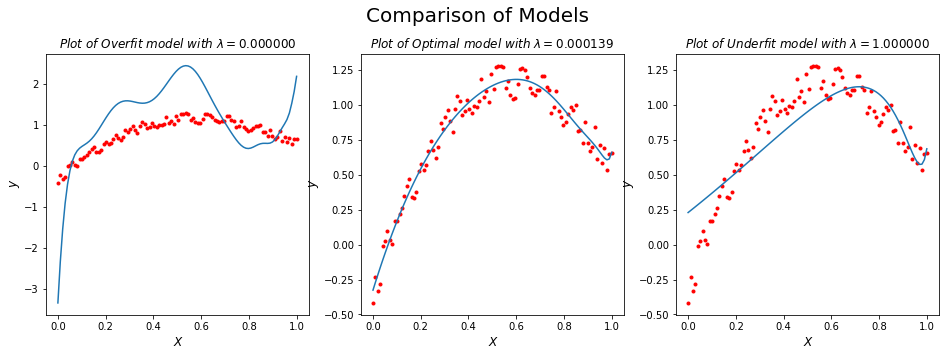

In [17]:
# Create the inputs for the plotting and call the plot function
plot_dict = {"Overfit": 0, "Optimal": opt_lambda, "Underfit": lambdas[-1]}

plot_lambda_models(plot_dict, X_train, y_train)

### Conclusions for Task 5

The values shown above indicate show that the cross-validation chose a lower score for $\lambda$ - 0.000139 - than the value selected when not using cross-validation - 0.0007.  

The plot of $E_{cv} vs. \lambda$ above also shows that the estimate of $E_{out}$ degrades more rapidly and to a higher value in using the cross-validated approach.

Both of these data points show the value of cross-validation.  By better utilising the data available, and conducting more experiments, we were able to determine:

 - A more optimal version of the regularisation parameter
 - A more accurate reflection of how the estimate of $E_{out}$ changes with respect to $\lambda$.
 
It is worth noting, however, that the plot for both optimal $\lambda$ values are not very different, despite being relatively far apart.  This suggests that while the fit is responsive to small $\lambda$ values, there are a wide range of such values that would give the same (or similar) result.  

This allows the conclusion that **_the absolute optimal $\lambda$ does not necessarily have to be computed._**


-----

## Task 6

Use `RidgeCV` and `LassoCV` to obtain optimum $\lambda$ using the same transformed data as above (`X_trans`).

Not that both algorithms refer to the $\alpha$ parameter, which in this case corresponds to the value of $\lambda$.



### Ridge Regression 

Ridge Regression adds _L2 Regularision_ to the regression calculation.  This penalises the sum of the squared coefficients (weights).  Weights that are too large are constrained to smaller values.

For a comparison to the test results above, I've opted to set the `cv` parameter to `None`.  This will cause Ridge to use _Leave-One-Out_ cross-validation and should make it a more interesting comparison to the above.  To avoid an error, however it's necessary to leave out the first element of the previously used $\lambda$ values ($\lambda_0 = 0$).

Lambda from Ridge = 5.751217071841614e-05


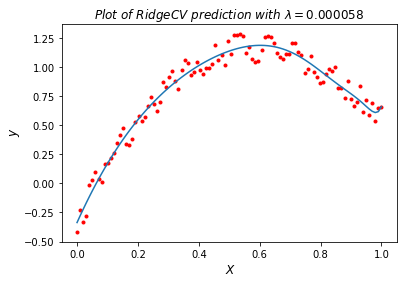

In [18]:
# Need to remove lambda=0 when cv is set to None as it performs Leave-one-out in this mode
ridge_cv = RidgeCV(lambdas[1:], cv=None)
ridge_cv.fit(X_train, y_train)

print(f"Lambda from Ridge = {ridge_cv.alpha_}")

# Plot the original and Ridge predicted functions
plt.plot(X,y,'r.')
plt.plot(X, ridge_cv.predict(X_trans))

plt.title(f"Plot of RidgeCV prediction with $\lambda = {ridge_cv.alpha_:.6f}$", fontsize='large', fontstyle='italic')    
plt.xlabel("X", fontsize='large', fontstyle='italic')
plt.ylabel("y", fontsize='large', fontstyle='italic')

plt.show()

### Lasso

Lasso performs adds _L1 Regularision_ to the regression calculation.  This penalises the sum of the absolute values of the coefficients (weights).  For some values of $\lambda$ it can make some coefficients (weights) 0.  These are features that are essentially colinear, which means Lasso can act as a feature selection mechanism.

For a comparison to the test results above, I've opted to not specify the `alphas` parameter to the model.  `LassoCV` will choose it's own values for `alphas` instead so it will be a more interesting comparison.  We will force the model to use the same number of $\lambda$ values, however.

-----

**Note for Tutor/Lecturer**

While the notebook asks for no additional imports, this import has been added just to suppress the warnings about convergence that will occur when LassoCV is executed (*max_iter*=1000 by default).  This is to make the notebook clearer to follow and no other functional imports have been used.

In [19]:
# In the event the algorithm doesn't converge (likely) then we don't want to get warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

D:\Masters\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Lambda from Lasso = 6.866467224101996e-05


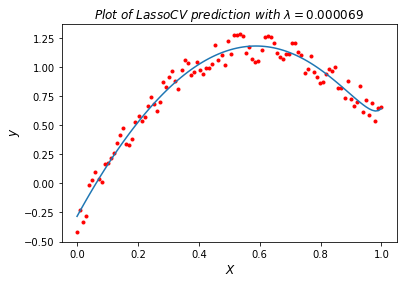

In [20]:
lasso_cv = LassoCV(n_alphas=len(lambdas))
lasso_cv.fit(X_train, y_train)

print(f"Lambda from Lasso = {lasso_cv.alpha_}")

# Plot the original and Lasso predicted functions
plt.plot(X,y,'r.')
plt.plot(X, lasso_cv.predict(X_trans))

plt.title(f"Plot of LassoCV prediction with $\lambda = {lasso_cv.alpha_:.6f}$", fontsize='large', fontstyle='italic')    
plt.xlabel("X", fontsize='large', fontstyle='italic')
plt.ylabel("y", fontsize='large', fontstyle='italic')

plt.show()

Of note in this plot is that the predicted line is smoother, without the kinks seen in the other plots.

### Comparison of $E_{out}$ and $\lambda$ values

In [21]:
# Modification of earlier function to account for already predicted values
# e.g. from RidgeCV and LassoCV
def calc_error_from_pred (pred, y):
    return math.sqrt((pred-np.array(y)).dot(pred-np.array(y))/len(y))

In [22]:
print(f"The lambda value from RidgeCV = {ridge_cv.alpha_:.6f}")
print(f"The lambda value from LassoCV = {lasso_cv.alpha_:.6f}")
print()

# Calculate Eout based on the held out test set
ridge_eout = calc_error_from_pred(y_test, ridge_cv.predict(X_test))
lasso_eout = calc_error_from_pred(y_test, lasso_cv.predict(X_test))

print(f"The value of Eout for RidgeCV = {ridge_eout:.6f}")
print(f"The value of Eout for LassoCV = {lasso_eout:.6f}")

The lambda value from RidgeCV = 0.000058
The lambda value from LassoCV = 0.000069

The value of Eout for RidgeCV = 0.079793
The value of Eout for LassoCV = 0.078354


In [23]:
print("Summary of Eout values\n")
print("Single\t\tKFold\t\tRidge\t\tLasso")
print("===========\t===========\t===========\t===========")
print(f"{min_eout:.6f}\t{min_e_cv:.6f}\t{ridge_eout:.6f}\t{lasso_eout:.6f}")

print("\n\nSummary of lambda values\n")
print("Single\t\tKFold\t\tRidge\t\tLasso")
print("===========\t===========\t===========\t===========")
print(f"{lambda_min_eout:.6f}\t{opt_lambda:.6f}\t{ridge_cv.alpha_:.6f}\t{lasso_cv.alpha_:.6f}")

Summary of Eout values

Single		KFold		Ridge		Lasso
===========	===========	===========	===========
0.077487	0.083703	0.079793	0.078354


Summary of lambda values

Single		KFold		Ridge		Lasso
===========	===========	===========	===========
0.000743	0.000139	0.000058	0.000069


The comparison of the $E_{out}$ values (i.e. the prediction on the held-out test set) shows them all to be in a similar range.  

It's interesting to note the discrepancy in $E_{out}$ for KFold and Ridge, given that they use the same $\lambda$ values.  They essentially the same approach.  Also see the following comparison of weights for similarity in the weights chosen.

The similarity of the $E_{out}$ values also shows another interesting feature.  Of the distinct approaches (Single, KFold/Ridge, Lasso) the $\lambda$ values are spread across a range that runs an over an order of magnitude, yet $E_{out} is essentially the same.

The single pass represents the lowest value, however this may not represent the full picture of the model.  The size of the test set is small, and the greater amount of training and validation on the other approaches should yield a more realistic assessment of the data.

### Comparison of weights


In [24]:
print("Single\t\tKFold\t\tRidge\t\tLasso")
print("===========\t===========\t===========\t===========")

for weight, cv_weight, ridge_weight, lasso_weight in zip(weight_min_eout, w_opt, ridge_cv.coef_, lasso_cv.coef_):
    print(f"{weight: .8f}\t{cv_weight: .8f}\t{ridge_weight: .8f}\t{lasso_weight: .8f}")

Single		KFold		Ridge		Lasso
===========	===========	===========	===========
-0.29750710	-0.32547592	 0.00000000	 0.00000000
 4.96429942	 5.53348260	 5.81714117	 4.76650742
-4.04757933	-6.40622219	-7.86369560	-3.50002678
-0.50759812	 1.94010471	 4.07379996	-0.63208251
 0.50653622	 1.52952296	 1.69599811	-0.00000000
 0.29227542	-0.26341818	-1.18901677	-0.00000000
-0.08577798	-1.18124963	-2.05863128	-0.00000000
-0.30665781	-1.23514236	-1.63761383	 0.00000000
-0.35233805	-0.84185003	-0.77923927	 0.00000000
-0.28440176	-0.32935185	 0.03333994	 0.00000000
-0.16517426	 0.12243090	 0.60882471	 0.00000000
-0.03796660	 0.44171864	 0.91731812	 0.00000000
 0.07270899	 0.61892679	 1.00058331	 0.03910843
 0.15597789	 0.67420472	 0.92243821	 0.08915529
 0.20949624	 0.63820469	 0.74510415	 0.05550545
 0.23564057	 0.54199895	 0.51991281	 0.02583523
 0.23899363	 0.41249417	 0.28512619	 0.00153382
 0.22481648	 0.27086818	 0.06687550	 0.00000000
 0.19819173	 0.13253808	-0.11878939	 0.00000000
 0.16359606	

The output above shows that Lasso has chosen to zero-out most of the weights and effectively remove these features from the model.  By contrast no weights in Ridge are reduced to 0.  Given the definition of the weight penalties - Sum of Square Coefficients/L2 for Ridge, Sum of Absolute Coefficients/L1 for Lasso - this difference is expected.  

What is unexpected is the amount of parameters that Lasso has essentially removed from the model.

### Final Conclusion

Although the different models all produced similar values for $E_{out}$, there is a clear difference in the final weights chosen by the Single, KFold/RidgeCV and LassoCV approaches.  The KFold/RidgeCV models used the same lambda values and essentially the same error function so the results are much the same.

When taking the weights and the optimum $\lambda$ into account amongst the selection, the model generated by Lasso is the best of them as it represents the simplest model amongst the group.